### 물체 인식률 실험

In [1]:
import open3d as o3d
import numpy as np
import os
import sys
import open3d as o3d
import cv2
import copy
import matplotlib.pyplot as plt
# os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
# sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/perception'))
# sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))
# from scripts.milestone_202110.utils.detection_util import *
from util.multiICP import *
from test_util import *

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder

In [3]:
import PIL
from cv2 import aruco
import matplotlib as mpl
import pandas as pd

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
# fig = plt.figure()
# nx = 2
# ny = 2
# for i in range(1, nx*ny+1):
#     ax = fig.add_subplot(ny,nx, i)
#     img = aruco.drawMarker(aruco_dict,i+229, 800)
#     plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
#     ax.axis("off")
# plt.savefig("target_markers.pdf")

# # Save Aruco Marker Image
# for i in range(6):
#     idx = i+230
#     img = aruco.drawMarker(aruco_dict, idx, 800)
#     cv2.imwrite("marker_{}.png".format(idx), img)

In [4]:
cameraMatrix = np.array([[899.05322266,   0.        , 654.88366699],
                          [  0.        , 899.21044922, 352.92956543],
                          [  0.        ,   0.        ,   1.        ]])
distCoeffs = np.array([ 0.15870179, -0.46903715, -0.0014261 ,  0.00066797,  0.41631824])

### Mini_table

In [5]:
path = './save_img/mini_table'

In [8]:
# camera-streaming
cam_streaming(path)

./save_img/mini_table not empty. Overwrite? (y/n) : y
Saved color + depth image 0
Saved color + depth image 1
Saved color + depth image 2
Saved color + depth image 3
Saved color + depth image 4
Saved color + depth image 5
Saved color + depth image 6
Saved color + depth image 7
Saved color + depth image 8
Saved color + depth image 9
Saved color + depth image 10
Saved color + depth image 11
Saved color + depth image 12
Saved color + depth image 13
Saved color + depth image 14
Saved color + depth image 15
Saved color + depth image 16
Saved color + depth image 17
Saved color + depth image 18
Saved color + depth image 19
Stop the streaming and Save RGBD images



In [37]:
mini_table_iou = []

In [ ]:
for i in range(20):
    color_path = os.path.join(path, 'color_segmented/color_mask_{}.jpg'.format(i))
    depth_path = os.path.join(path, 'depth_segmented/depth_mask_{}.png'.format(i))
    cdp_masked = load_cdp(color_path, depth_path)
    
    icp_table = MultiICP(model='model_CAD/mini_table.STL',
                     Toff=SE3(np.identity(3),(0,0,0)), scale=[1e-3,1e-3,1e-3])
    icp_table.add_image(cdp_masked, Tc=None)

#     Tguess = SE3(Rot_axis(1, 2*np.pi/3), (-0.15,0,0.7))
    Tguess = icp_table.get_initial_by_center(Rot_axis(1, 2*np.pi/3), offset=(-0.27,0.2,0))
    T_co1, fitness1 = icp_table.compute_ICP(To=Tguess, thres=0.2, visualize=False)
#     T_co2, fitness2 = icp_table.compute_ICP(To=None, thres=0.3, visualize=False)
    
#     if fitness1 > fitness2:
#         T_co = T_co1
#     else:
#         T_co = T_co2
    T_co = T_co1
    color_image = cv2.imread(os.path.join(path, 'color/color_{}.jpg').format(i))
    objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
    # img_out = aruco_map.draw_objects(color_image, objectPose_dict, corner_dict, cameraMatrix, distCoeffs)
    # plt.imshow(img_out[:,:,[2,1,0]])
    
    T_cm = objectPose_dict['test_table']
    T_mo = SE3(Rot_axis(3, -np.pi/2), (-0.09, 0.03, -0.265))
    T_co_gt = np.matmul(T_cm, T_mo)
    T_co, T_co_gt
    
    T_off = np.matmul(SE3_inv(T_co_gt), T_co)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=(0,0,0))

    mesh = o3d.io.read_triangle_mesh('model_CAD/mini_table.STL')
    mesh_gt = o3d.io.read_triangle_mesh('model_CAD/mini_table.STL')
    mesh.vertices = o3d.utility.Vector3dVector(
        np.asarray(mesh.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))
    mesh_gt.vertices = o3d.utility.Vector3dVector(
        np.asarray(mesh_gt.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))
    mesh.transform(T_off)
    # mesh_gt.transform(T_co_gt)
    aabox = mesh.get_oriented_bounding_box()
    aabox_gt = mesh_gt.get_oriented_bounding_box()

#     o3d.visualization.draw_geometries([mesh, aabox, mesh_gt, aabox_gt, origin])
    
    points = np.asarray(aabox.get_box_points())
    points_gt = np.asarray(aabox_gt.get_box_points())
    # points = points[points[:,2].argsort()[::-1]]
    # points_gt = points_gt[points_gt[:,2].argsort()[::-1]]
    
#     iou_3d = get_3d_iou(aabox, aabox_gt, points, points_gt)
    iou_3d = get_iou_3d(aabox, aabox_gt, points, points_gt, T_off)
    mini_table_iou.append(iou_3d)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.174640e-02, and correspondence_set size of 104717
Access transformation to get result.
Transformation is:
[[ 9.66935940e-01 -2.55018642e-01  6.15668480e-04 -1.83204047e-01]
 [-1.74754645e-01 -6.64359065e-01 -7.26696512e-01  2.74346874e-01]
 [ 1.85730187e-01  7.02561384e-01 -6.86958349e-01  7.56919479e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('IOU_3d:', 0.8982483712101996)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.467465e-02, and correspondence_set size of 113267
Access transformation to get result.


In [11]:
mini_table_iou

[0.9008399949820763,
 0.9488211825699572,
 0.9583546310654207,
 0.9595233824358326,
 0.949028109728505,
 0.9847561061012453,
 0.926509139701379,
 0.9877676932249573,
 0.9739216781718443,
 0.9745588147637453,
 0.9910014535910397,
 0.9742071899774933,
 0.9958101276600941,
 0.994318188036405,
 0.9945751689815362,
 0.8266161964017033,
 0.8120396987600164,
 0.8509972625593137,
 0.9420004486898014,
 0.8996506300953329,
 0.8966588521894633,
 0.9539019866051452,
 0.9588264080384293,
 0.9589412379607286,
 0.951252609807573,
 0.9836328224036086,
 0.91782692184699,
 0.9844034710147096,
 0.9799028689276218,
 0.974619088032805,
 0.9916192202481787,
 0.9726587972949357,
 0.9957340312991029,
 0.9855858762400451,
 0.9950253928428436,
 0.8304446968025624,
 0.8141240938224047,
 0.8506447811140271,
 0.9479622236021031,
 0.9028703306547066]

In [12]:
np.savetxt('mini_table_iou_result.txt', np.array(mini_table_iou))

### Washstand

In [7]:
path = './save_img/washstand'

In [ ]:
# camera-streaming
cam_streaming(path)

In [8]:
washstand_iou = []

In [19]:
for j in range(20):
    color_path = os.path.join(path, 'color_segmented/color_mask_{}.jpg'.format(j))
    depth_path = os.path.join(path, 'depth_segmented/depth_mask_{}.png'.format(j))
    cdp_masked = load_cdp(color_path, depth_path)

    icp_washstand = MultiICP(model='model_CAD/washstand.stl',
                     Toff=SE3(np.identity(3),(0,0,0)), scale=[1.12e-2,1.4e-2,1.1e-2])
    icp_washstand.add_image(cdp_masked, Tc=None)

    scale=[1.12e-2,1.4e-2,1.1e-2]
    wash_model = o3d.io.read_triangle_mesh('model_CAD/washstand.stl')
    wash_model.vertices = o3d.utility.Vector3dVector(
                    np.asarray(wash_model.vertices) * np.array([scale[0], scale[1], scale[2]]))

    wash_pcd = wash_model.sample_points_uniformly(int(len(np.asarray(icp_washstand.pcd.points))*0.7))
    points = np.asarray(wash_pcd.points)

    idx = []
    for i in range(len(points)):
        if points[i, 2] > 0.65:
            idx.append(i)

    pts = np.zeros((len(idx), 3))
    for i in range(len(idx)):
        pts[i] = points[idx[i]]

    cut_pcd = o3d.geometry.PointCloud()
    cut_pcd.points = o3d.utility.Vector3dVector(pts)
    icp_washstand.model_sampled = cut_pcd
    
    Tguess = icp_washstand.get_initial_by_center(Rot_axis(1, 2*np.pi/3), offset=(-0.05,0.6,0.6))
    T_co1, fitness1 = icp_washstand.compute_ICP(To=Tguess, thres=0.15, visualize=False)
    
    T_co = T_co1
    
    color_image = cv2.imread(os.path.join(path, 'color/color_{}.jpg'.format(j)))
    objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
#     img_out = aruco_map.draw_objects(color_image, objectPose_dict, corner_dict, cameraMatrix, distCoeffs)
#     plt.imshow(img_out[:,:,[2,1,0]])

    T_cm = objectPose_dict['test_table']
    T_mo = SE3(Rot_axis(1, -np.pi/2), (0.275, -1.065, -0.01))
    T_co_gt = np.matmul(T_cm, T_mo)

    T_off = np.matmul(SE3_inv(T_co_gt), T_co)
    
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=(0,0,0))
    mesh = o3d.io.read_triangle_mesh('model_CAD/washstand.stl')
    mesh_gt = o3d.io.read_triangle_mesh('model_CAD/washstand.stl')
    mesh.vertices = o3d.utility.Vector3dVector(
                    np.asarray(mesh.vertices) * np.array([scale[0], scale[1], scale[2]]))
    mesh_gt.vertices = o3d.utility.Vector3dVector(
                    np.asarray(mesh_gt.vertices) * np.array([scale[0], scale[1], scale[2]]))
    mesh.transform(T_off)
    # mesh_gt.transform(T_co_gt)
    # aabox = mesh.get_oriented_bounding_box()
    # aabox_gt = mesh_gt.get_oriented_bounding_box()
    aabox = mesh.get_axis_aligned_bounding_box()
    aabox_gt = mesh_gt.get_axis_aligned_bounding_box()

    o3d.visualization.draw_geometries([mesh, aabox, mesh_gt, aabox_gt, origin])
    points = np.asarray(aabox.get_box_points())
    points_gt = np.asarray(aabox_gt.get_box_points())
    # points = points[points[:,2].argsort()[::-1]]
    # points_gt = points_gt[points_gt[:,2].argsort()[::-1]]
    
#     iou_3d = get_3d_iou(aabox, aabox_gt, points, points_gt)
    iou_3d = get_iou_3d(aabox, aabox_gt, points, points_gt, T_off)
    washstand_iou.append(iou_3d)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.126235e-02, and correspondence_set size of 12652
Access transformation to get result.
Transformation is:
[[ 0.94855799 -0.27744427 -0.15252021  0.23635895]
 [-0.17581348 -0.06095982 -0.98253422  0.90379908]
 [ 0.26330089  0.95880579 -0.10660237  1.54655713]
 [ 0.          0.          0.          1.        ]]
('IOU_3d:', 0.7225742789413863)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.197208e-02, and correspondence_set size of 15219
Access transformation to get result.
Transformation is:
[[ 0.96367538 -0.24668491 -0.1023539   0.46585242]
 [-0.13376014 -0.11407883 -0.98442583  0.85516376]
 [ 0.23116659  0.96235781 -0.14293157  1.51723496]
 [ 0.          0.          0.          1.        ]]
('IOU_3d:', 0.7338966054331596)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.281762e-02, and cor

('IOU_3d:', 0.7875583022714301)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.449335e-02, and correspondence_set size of 25907
Access transformation to get result.
Transformation is:
[[ 0.89115442 -0.45096134  0.04977615 -0.06044507]
 [ 0.0175446  -0.07537656 -0.99700077  0.8711709 ]
 [ 0.45336077  0.88935494 -0.05926022  1.09556706]
 [ 0.          0.          0.          1.        ]]
('IOU_3d:', 0.7414062980207508)


In [20]:
washstand_iou

[0.7190411873899111,
 0.7337344901099656,
 0.6993274082685952,
 0.7581398377249895,
 0.7274780633966923,
 0.7227006071736695,
 0.7247007559763499,
 0.7218213484103029,
 0.7589991221132633,
 0.7844433018186099,
 0.7308244254632519,
 0.7218578835076943,
 0.7044512089222847,
 0.45772056769694447,
 0.4521389909066219,
 0.49511669646824136,
 0.7088317436154856,
 0.7547272620498919,
 0.7894921866602548,
 0.7675252149235954,
 0.7225742789413863,
 0.7338966054331596,
 0.7072718790593377,
 0.7614248910540953,
 0.7575112103365506,
 0.7177455217536399,
 0.7269456068263914,
 0.7186967019364725,
 0.763219243625673,
 0.7988308268643943,
 0.7322480053499814,
 0.7218094557238595,
 0.6928324964802002,
 0.45781795150704,
 0.449714829097861,
 0.4983204320347501,
 0.7026471478043934,
 0.7596140764267661,
 0.7875583022714301,
 0.7414062980207508]

In [21]:
np.savetxt('washstand_iou_result.txt', np.array(washstand_iou))

### Bed & Closet

In [5]:
INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(None, None))
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                           None, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, False])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)
import os
import sys
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))
from demo_utils.environment import add_cam, add_bed, add_closet, move_bed, move_closet

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = [0]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)

connection command:
kmb0: False
indy1: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [6]:
path = './save_img/bed'

In [4]:
# camera-streaming
cam_streaming(path)

./save_img/bed not empty. Overwrite? (y/n) : y
Saved color + depth image 0
Saved color + depth image 1
Saved color + depth image 2
Saved color + depth image 3
Saved color + depth image 4
Saved color + depth image 5
Saved color + depth image 6
Saved color + depth image 7
Saved color + depth image 8
Saved color + depth image 9
Saved color + depth image 10
Saved color + depth image 11
Saved color + depth image 12
Saved color + depth image 13
Saved color + depth image 14
Saved color + depth image 15
Saved color + depth image 16
Saved color + depth image 17
Saved color + depth image 18
Saved color + depth image 19
Saved color + depth image 20
Saved color + depth image 21
Saved color + depth image 22
Saved color + depth image 23
Saved color + depth image 24
Saved color + depth image 25
Saved color + depth image 26
Saved color + depth image 27
Saved color + depth image 28
Saved color + depth image 29
Saved color + depth image 30
Saved color + depth image 31
Saved color + depth image 32
Saved 

Saved color + depth image 279
Saved color + depth image 280
Saved color + depth image 281
Saved color + depth image 282
Saved color + depth image 283
Saved color + depth image 284
Saved color + depth image 285
Saved color + depth image 286
Saved color + depth image 287
Saved color + depth image 288
Saved color + depth image 289
Saved color + depth image 290
Saved color + depth image 291
Saved color + depth image 292
Saved color + depth image 293
Saved color + depth image 294
Saved color + depth image 295
Saved color + depth image 296
Saved color + depth image 297
Saved color + depth image 298
Saved color + depth image 299
Saved color + depth image 300
Saved color + depth image 301
Saved color + depth image 302
Saved color + depth image 303
Saved color + depth image 304
Saved color + depth image 305
Saved color + depth image 306
Saved color + depth image 307
Saved color + depth image 308
Saved color + depth image 309
Saved color + depth image 310
Saved color + depth image 311
Saved colo

Saved color + depth image 554
Saved color + depth image 555
Saved color + depth image 556
Saved color + depth image 557
Saved color + depth image 558
Saved color + depth image 559
Saved color + depth image 560
Saved color + depth image 561
Saved color + depth image 562
Saved color + depth image 563
Saved color + depth image 564
Saved color + depth image 565
Saved color + depth image 566
Saved color + depth image 567
Saved color + depth image 568
Saved color + depth image 569
Saved color + depth image 570
Saved color + depth image 571
Saved color + depth image 572
Saved color + depth image 573
Saved color + depth image 574
Saved color + depth image 575
Saved color + depth image 576
Saved color + depth image 577
Saved color + depth image 578
Saved color + depth image 579
Saved color + depth image 580
Saved color + depth image 581
Saved color + depth image 582
Saved color + depth image 583
Saved color + depth image 584
Saved color + depth image 585
Saved color + depth image 586
Saved colo

Saved color + depth image 830
Saved color + depth image 831
Saved color + depth image 832
Saved color + depth image 833
Saved color + depth image 834
Saved color + depth image 835
Saved color + depth image 836
Saved color + depth image 837
Saved color + depth image 838
Saved color + depth image 839
Saved color + depth image 840
Saved color + depth image 841
Saved color + depth image 842
Saved color + depth image 843
Saved color + depth image 844
Saved color + depth image 845
Saved color + depth image 846
Saved color + depth image 847
Saved color + depth image 848
Saved color + depth image 849
Saved color + depth image 850
Saved color + depth image 851
Saved color + depth image 852
Saved color + depth image 853
Saved color + depth image 854
Saved color + depth image 855
Saved color + depth image 856
Saved color + depth image 857
Saved color + depth image 858
Saved color + depth image 859
Saved color + depth image 860
Saved color + depth image 861
Saved color + depth image 862
Saved colo

Saved color + depth image 1100
Saved color + depth image 1101
Saved color + depth image 1102
Saved color + depth image 1103
Saved color + depth image 1104
Saved color + depth image 1105
Saved color + depth image 1106
Saved color + depth image 1107
Saved color + depth image 1108
Saved color + depth image 1109
Saved color + depth image 1110
Saved color + depth image 1111
Saved color + depth image 1112
Saved color + depth image 1113
Saved color + depth image 1114
Saved color + depth image 1115
Saved color + depth image 1116
Saved color + depth image 1117
Saved color + depth image 1118
Saved color + depth image 1119
Saved color + depth image 1120
Saved color + depth image 1121
Saved color + depth image 1122
Saved color + depth image 1123
Saved color + depth image 1124
Saved color + depth image 1125
Saved color + depth image 1126
Saved color + depth image 1127
Saved color + depth image 1128
Saved color + depth image 1129
Saved color + depth image 1130
Saved color + depth image 1131
Saved co

Saved color + depth image 1370
Saved color + depth image 1371
Saved color + depth image 1372
Saved color + depth image 1373
Saved color + depth image 1374
Saved color + depth image 1375
Saved color + depth image 1376
Saved color + depth image 1377
Saved color + depth image 1378
Saved color + depth image 1379
Saved color + depth image 1380
Saved color + depth image 1381
Saved color + depth image 1382
Saved color + depth image 1383
Saved color + depth image 1384
Saved color + depth image 1385
Saved color + depth image 1386
Saved color + depth image 1387
Saved color + depth image 1388
Saved color + depth image 1389
Saved color + depth image 1390
Saved color + depth image 1391
Saved color + depth image 1392
Saved color + depth image 1393
Saved color + depth image 1394
Saved color + depth image 1395
Saved color + depth image 1396
Saved color + depth image 1397
Saved color + depth image 1398
Saved color + depth image 1399
Saved color + depth image 1400
Saved color + depth image 1401
Saved co

Saved color + depth image 1638
Saved color + depth image 1639
Saved color + depth image 1640
Saved color + depth image 1641
Saved color + depth image 1642
Saved color + depth image 1643
Saved color + depth image 1644
Saved color + depth image 1645
Saved color + depth image 1646
Saved color + depth image 1647
Saved color + depth image 1648
Saved color + depth image 1649
Saved color + depth image 1650
Saved color + depth image 1651
Saved color + depth image 1652
Saved color + depth image 1653
Saved color + depth image 1654
Saved color + depth image 1655
Saved color + depth image 1656
Saved color + depth image 1657
Saved color + depth image 1658
Saved color + depth image 1659
Saved color + depth image 1660
Saved color + depth image 1661
Saved color + depth image 1662
Saved color + depth image 1663
Saved color + depth image 1664
Saved color + depth image 1665
Saved color + depth image 1666
Saved color + depth image 1667
Saved color + depth image 1668
Saved color + depth image 1669
Saved co

Saved color + depth image 1906
Saved color + depth image 1907
Saved color + depth image 1908
Saved color + depth image 1909
Saved color + depth image 1910
Saved color + depth image 1911
Saved color + depth image 1912
Saved color + depth image 1913
Saved color + depth image 1914
Saved color + depth image 1915
Saved color + depth image 1916
Saved color + depth image 1917
Saved color + depth image 1918
Saved color + depth image 1919
Saved color + depth image 1920
Saved color + depth image 1921
Saved color + depth image 1922
Saved color + depth image 1923
Saved color + depth image 1924
Saved color + depth image 1925
Saved color + depth image 1926
Saved color + depth image 1927
Saved color + depth image 1928
Saved color + depth image 1929
Saved color + depth image 1930
Saved color + depth image 1931
Saved color + depth image 1932
Saved color + depth image 1933
Saved color + depth image 1934
Saved color + depth image 1935
Saved color + depth image 1936
Saved color + depth image 1937
Saved co

Saved color + depth image 2174
Saved color + depth image 2175
Saved color + depth image 2176
Saved color + depth image 2177
Saved color + depth image 2178
Saved color + depth image 2179
Saved color + depth image 2180
Saved color + depth image 2181
Saved color + depth image 2182
Saved color + depth image 2183
Saved color + depth image 2184
Saved color + depth image 2185
Saved color + depth image 2186
Saved color + depth image 2187
Saved color + depth image 2188
Saved color + depth image 2189
Saved color + depth image 2190
Saved color + depth image 2191
Saved color + depth image 2192
Saved color + depth image 2193
Saved color + depth image 2194
Saved color + depth image 2195
Saved color + depth image 2196
Saved color + depth image 2197
Saved color + depth image 2198
Saved color + depth image 2199
Saved color + depth image 2200
Saved color + depth image 2201
Saved color + depth image 2202
Saved color + depth image 2203
Saved color + depth image 2204
Saved color + depth image 2205
Saved co

Saved color + depth image 2444
Saved color + depth image 2445
Saved color + depth image 2446
Saved color + depth image 2447
Saved color + depth image 2448
Saved color + depth image 2449
Saved color + depth image 2450
Saved color + depth image 2451
Saved color + depth image 2452
Saved color + depth image 2453
Saved color + depth image 2454
Saved color + depth image 2455
Saved color + depth image 2456
Saved color + depth image 2457
Saved color + depth image 2458
Saved color + depth image 2459
Saved color + depth image 2460
Saved color + depth image 2461
Saved color + depth image 2462
Saved color + depth image 2463
Saved color + depth image 2464
Saved color + depth image 2465
Saved color + depth image 2466
Saved color + depth image 2467
Saved color + depth image 2468
Saved color + depth image 2469
Saved color + depth image 2470
Saved color + depth image 2471
Saved color + depth image 2472
Saved color + depth image 2473
Saved color + depth image 2474
Saved color + depth image 2475
Saved co

Saved color + depth image 2714
Saved color + depth image 2715
Saved color + depth image 2716
Saved color + depth image 2717
Saved color + depth image 2718
Saved color + depth image 2719
Saved color + depth image 2720
Saved color + depth image 2721
Saved color + depth image 2722
Saved color + depth image 2723
Saved color + depth image 2724
Saved color + depth image 2725
Saved color + depth image 2726
Saved color + depth image 2727
Saved color + depth image 2728
Saved color + depth image 2729
Saved color + depth image 2730
Saved color + depth image 2731
Saved color + depth image 2732
Saved color + depth image 2733
Saved color + depth image 2734
Saved color + depth image 2735
Saved color + depth image 2736
Saved color + depth image 2737
Saved color + depth image 2738
Saved color + depth image 2739
Saved color + depth image 2740
Saved color + depth image 2741
Saved color + depth image 2742
Saved color + depth image 2743
Saved color + depth image 2744
Saved color + depth image 2745
Saved co

Saved color + depth image 2984
Saved color + depth image 2985
Saved color + depth image 2986
Saved color + depth image 2987
Saved color + depth image 2988
Saved color + depth image 2989
Saved color + depth image 2990
Saved color + depth image 2991
Saved color + depth image 2992
Saved color + depth image 2993
Saved color + depth image 2994
Saved color + depth image 2995
Saved color + depth image 2996
Saved color + depth image 2997
Saved color + depth image 2998
Saved color + depth image 2999
Saved color + depth image 3000
Saved color + depth image 3001
Saved color + depth image 3002
Saved color + depth image 3003
Saved color + depth image 3004
Saved color + depth image 3005
Saved color + depth image 3006
Saved color + depth image 3007
Saved color + depth image 3008
Saved color + depth image 3009
Saved color + depth image 3010
Saved color + depth image 3011
Saved color + depth image 3012
Saved color + depth image 3013
Saved color + depth image 3014
Saved color + depth image 3015
Saved co

Saved color + depth image 3252
Saved color + depth image 3253
Saved color + depth image 3254
Saved color + depth image 3255
Saved color + depth image 3256
Saved color + depth image 3257
Saved color + depth image 3258
Saved color + depth image 3259
Saved color + depth image 3260
Saved color + depth image 3261
Saved color + depth image 3262
Saved color + depth image 3263
Saved color + depth image 3264
Saved color + depth image 3265
Saved color + depth image 3266
Saved color + depth image 3267
Saved color + depth image 3268
Saved color + depth image 3269
Saved color + depth image 3270
Saved color + depth image 3271
Saved color + depth image 3272
Saved color + depth image 3273
Saved color + depth image 3274
Saved color + depth image 3275
Saved color + depth image 3276
Saved color + depth image 3277
Saved color + depth image 3278
Saved color + depth image 3279
Saved color + depth image 3280
Saved color + depth image 3281
Saved color + depth image 3282
Saved color + depth image 3283
Saved co

Saved color + depth image 3520
Saved color + depth image 3521
Saved color + depth image 3522
Saved color + depth image 3523
Saved color + depth image 3524
Saved color + depth image 3525
Saved color + depth image 3526
Saved color + depth image 3527
Saved color + depth image 3528
Saved color + depth image 3529
Saved color + depth image 3530
Saved color + depth image 3531
Saved color + depth image 3532
Saved color + depth image 3533
Saved color + depth image 3534
Saved color + depth image 3535
Saved color + depth image 3536
Saved color + depth image 3537
Saved color + depth image 3538
Saved color + depth image 3539
Saved color + depth image 3540
Saved color + depth image 3541
Saved color + depth image 3542
Saved color + depth image 3543
Saved color + depth image 3544
Saved color + depth image 3545
Saved color + depth image 3546
Saved color + depth image 3547
Saved color + depth image 3548
Saved color + depth image 3549
Saved color + depth image 3550
Saved color + depth image 3551
Saved co

Saved color + depth image 3789
Saved color + depth image 3790
Saved color + depth image 3791
Saved color + depth image 3792
Saved color + depth image 3793
Saved color + depth image 3794
Saved color + depth image 3795
Saved color + depth image 3796
Saved color + depth image 3797
Saved color + depth image 3798
Saved color + depth image 3799
Saved color + depth image 3800
Saved color + depth image 3801
Saved color + depth image 3802
Saved color + depth image 3803
Saved color + depth image 3804
Saved color + depth image 3805
Saved color + depth image 3806
Saved color + depth image 3807
Saved color + depth image 3808
Saved color + depth image 3809
Saved color + depth image 3810
Saved color + depth image 3811
Saved color + depth image 3812
Saved color + depth image 3813
Saved color + depth image 3814
Saved color + depth image 3815
Saved color + depth image 3816
Saved color + depth image 3817
Saved color + depth image 3818
Saved color + depth image 3819
Saved color + depth image 3820
Saved co

Saved color + depth image 4054
Saved color + depth image 4055
Saved color + depth image 4056
Saved color + depth image 4057
Saved color + depth image 4058
Saved color + depth image 4059
Saved color + depth image 4060
Saved color + depth image 4061
Saved color + depth image 4062
Saved color + depth image 4063
Saved color + depth image 4064
Saved color + depth image 4065
Saved color + depth image 4066
Saved color + depth image 4067
Saved color + depth image 4068
Saved color + depth image 4069
Saved color + depth image 4070
Saved color + depth image 4071
Saved color + depth image 4072
Saved color + depth image 4073
Saved color + depth image 4074
Saved color + depth image 4075
Saved color + depth image 4076
Saved color + depth image 4077
Saved color + depth image 4078
Saved color + depth image 4079
Saved color + depth image 4080
Saved color + depth image 4081
Saved color + depth image 4082
Saved color + depth image 4083
Saved color + depth image 4084
Saved color + depth image 4085
Saved co

Saved color + depth image 4323
Saved color + depth image 4324
Saved color + depth image 4325
Saved color + depth image 4326
Saved color + depth image 4327
Saved color + depth image 4328
Saved color + depth image 4329
Saved color + depth image 4330
Saved color + depth image 4331
Saved color + depth image 4332
Saved color + depth image 4333
Saved color + depth image 4334
Saved color + depth image 4335
Saved color + depth image 4336
Saved color + depth image 4337
Saved color + depth image 4338
Saved color + depth image 4339
Saved color + depth image 4340
Saved color + depth image 4341
Saved color + depth image 4342
Saved color + depth image 4343
Saved color + depth image 4344
Saved color + depth image 4345
Saved color + depth image 4346
Saved color + depth image 4347
Saved color + depth image 4348
Saved color + depth image 4349
Saved color + depth image 4350
Saved color + depth image 4351
Saved color + depth image 4352
Saved color + depth image 4353
Saved color + depth image 4354
Saved co

Saved color + depth image 4593
Saved color + depth image 4594
Saved color + depth image 4595
Saved color + depth image 4596
Saved color + depth image 4597
Saved color + depth image 4598
Saved color + depth image 4599
Saved color + depth image 4600
Saved color + depth image 4601
Saved color + depth image 4602
Saved color + depth image 4603
Saved color + depth image 4604
Saved color + depth image 4605
Saved color + depth image 4606
Saved color + depth image 4607
Saved color + depth image 4608
Saved color + depth image 4609
Saved color + depth image 4610
Saved color + depth image 4611
Saved color + depth image 4612
Saved color + depth image 4613
Saved color + depth image 4614
Saved color + depth image 4615
Saved color + depth image 4616
Saved color + depth image 4617
Saved color + depth image 4618
Saved color + depth image 4619
Saved color + depth image 4620
Saved color + depth image 4621
Saved color + depth image 4622
Saved color + depth image 4623
Saved color + depth image 4624
Saved co

Saved color + depth image 4863
Saved color + depth image 4864
Saved color + depth image 4865
Saved color + depth image 4866
Saved color + depth image 4867
Saved color + depth image 4868
Saved color + depth image 4869
Saved color + depth image 4870
Saved color + depth image 4871
Saved color + depth image 4872
Saved color + depth image 4873
Saved color + depth image 4874
Saved color + depth image 4875
Saved color + depth image 4876
Saved color + depth image 4877
Saved color + depth image 4878
Saved color + depth image 4879
Saved color + depth image 4880
Saved color + depth image 4881
Saved color + depth image 4882
Saved color + depth image 4883
Saved color + depth image 4884
Saved color + depth image 4885
Saved color + depth image 4886
Saved color + depth image 4887
Saved color + depth image 4888
Saved color + depth image 4889
Saved color + depth image 4890
Saved color + depth image 4891
Saved color + depth image 4892
Saved color + depth image 4893
Saved color + depth image 4894
Saved co

Saved color + depth image 5131
Saved color + depth image 5132
Saved color + depth image 5133
Saved color + depth image 5134
Saved color + depth image 5135
Saved color + depth image 5136
Saved color + depth image 5137
Saved color + depth image 5138
Saved color + depth image 5139
Saved color + depth image 5140
Saved color + depth image 5141
Saved color + depth image 5142
Saved color + depth image 5143
Saved color + depth image 5144
Saved color + depth image 5145
Saved color + depth image 5146
Saved color + depth image 5147
Saved color + depth image 5148
Saved color + depth image 5149
Saved color + depth image 5150
Saved color + depth image 5151
Saved color + depth image 5152
Saved color + depth image 5153
Saved color + depth image 5154
Saved color + depth image 5155
Saved color + depth image 5156
Saved color + depth image 5157
Saved color + depth image 5158
Saved color + depth image 5159
Saved color + depth image 5160
Saved color + depth image 5161
Saved color + depth image 5162
Saved co

Saved color + depth image 5400
Saved color + depth image 5401
Saved color + depth image 5402
Saved color + depth image 5403
Saved color + depth image 5404
Saved color + depth image 5405
Saved color + depth image 5406
Saved color + depth image 5407
Saved color + depth image 5408
Saved color + depth image 5409
Saved color + depth image 5410
Saved color + depth image 5411
Saved color + depth image 5412
Saved color + depth image 5413
Saved color + depth image 5414
Saved color + depth image 5415
Saved color + depth image 5416
Saved color + depth image 5417
Saved color + depth image 5418
Saved color + depth image 5419
Saved color + depth image 5420
Saved color + depth image 5421
Saved color + depth image 5422
Saved color + depth image 5423
Saved color + depth image 5424
Saved color + depth image 5425
Saved color + depth image 5426
Saved color + depth image 5427
Saved color + depth image 5428
Saved color + depth image 5429
Saved color + depth image 5430
Saved color + depth image 5431
Saved co

Saved color + depth image 5669
Saved color + depth image 5670
Saved color + depth image 5671
Saved color + depth image 5672
Saved color + depth image 5673
Saved color + depth image 5674
Saved color + depth image 5675
Saved color + depth image 5676
Saved color + depth image 5677
Saved color + depth image 5678
Saved color + depth image 5679
Saved color + depth image 5680
Saved color + depth image 5681
Saved color + depth image 5682
Saved color + depth image 5683
Saved color + depth image 5684
Saved color + depth image 5685
Saved color + depth image 5686
Saved color + depth image 5687
Saved color + depth image 5688
Saved color + depth image 5689
Saved color + depth image 5690
Saved color + depth image 5691
Saved color + depth image 5692
Saved color + depth image 5693
Saved color + depth image 5694
Saved color + depth image 5695
Saved color + depth image 5696
Saved color + depth image 5697
Saved color + depth image 5698
Saved color + depth image 5699
Saved color + depth image 5700
Saved co

Saved color + depth image 5939
Saved color + depth image 5940
Saved color + depth image 5941
Saved color + depth image 5942
Saved color + depth image 5943
Saved color + depth image 5944
Saved color + depth image 5945
Saved color + depth image 5946
Saved color + depth image 5947
Saved color + depth image 5948
Saved color + depth image 5949
Saved color + depth image 5950
Saved color + depth image 5951
Saved color + depth image 5952
Saved color + depth image 5953
Saved color + depth image 5954
Saved color + depth image 5955
Saved color + depth image 5956
Saved color + depth image 5957
Saved color + depth image 5958
Saved color + depth image 5959
Saved color + depth image 5960
Saved color + depth image 5961
Saved color + depth image 5962
Saved color + depth image 5963
Saved color + depth image 5964
Saved color + depth image 5965
Saved color + depth image 5966
Saved color + depth image 5967
Saved color + depth image 5968
Saved color + depth image 5969
Saved color + depth image 5970
Saved co

Saved color + depth image 6208
Saved color + depth image 6209
Saved color + depth image 6210
Saved color + depth image 6211
Saved color + depth image 6212
Saved color + depth image 6213
Saved color + depth image 6214
Saved color + depth image 6215
Saved color + depth image 6216
Saved color + depth image 6217
Saved color + depth image 6218
Saved color + depth image 6219
Saved color + depth image 6220
Saved color + depth image 6221
Saved color + depth image 6222
Saved color + depth image 6223
Saved color + depth image 6224
Saved color + depth image 6225
Saved color + depth image 6226
Saved color + depth image 6227
Saved color + depth image 6228
Saved color + depth image 6229
Saved color + depth image 6230
Saved color + depth image 6231
Saved color + depth image 6232
Saved color + depth image 6233
Saved color + depth image 6234
Saved color + depth image 6235
Saved color + depth image 6236
Saved color + depth image 6237
Saved color + depth image 6238
Saved color + depth image 6239
Saved co

Saved color + depth image 6478
Saved color + depth image 6479
Saved color + depth image 6480
Saved color + depth image 6481
Saved color + depth image 6482
Saved color + depth image 6483
Saved color + depth image 6484
Saved color + depth image 6485
Saved color + depth image 6486
Saved color + depth image 6487
Saved color + depth image 6488
Saved color + depth image 6489
Saved color + depth image 6490
Saved color + depth image 6491
Saved color + depth image 6492
Saved color + depth image 6493
Saved color + depth image 6494
Saved color + depth image 6495
Saved color + depth image 6496
Saved color + depth image 6497
Saved color + depth image 6498
Saved color + depth image 6499
Saved color + depth image 6500
Saved color + depth image 6501
Saved color + depth image 6502
Saved color + depth image 6503
Saved color + depth image 6504
Saved color + depth image 6505
Saved color + depth image 6506
Saved color + depth image 6507
Saved color + depth image 6508
Saved color + depth image 6509
Saved co

Saved color + depth image 6748
Saved color + depth image 6749
Saved color + depth image 6750
Saved color + depth image 6751
Saved color + depth image 6752
Saved color + depth image 6753
Saved color + depth image 6754
Saved color + depth image 6755
Saved color + depth image 6756
Saved color + depth image 6757
Saved color + depth image 6758
Saved color + depth image 6759
Saved color + depth image 6760
Saved color + depth image 6761
Saved color + depth image 6762
Saved color + depth image 6763
Saved color + depth image 6764
Saved color + depth image 6765
Saved color + depth image 6766
Saved color + depth image 6767
Saved color + depth image 6768
Saved color + depth image 6769
Saved color + depth image 6770
Saved color + depth image 6771
Saved color + depth image 6772
Saved color + depth image 6773
Saved color + depth image 6774
Saved color + depth image 6775
Saved color + depth image 6776
Saved color + depth image 6777
Saved color + depth image 6778
Saved color + depth image 6779
Saved co

Saved color + depth image 7014
Saved color + depth image 7015
Saved color + depth image 7016
Saved color + depth image 7017
Saved color + depth image 7018
Saved color + depth image 7019
Saved color + depth image 7020
Saved color + depth image 7021
Saved color + depth image 7022
Saved color + depth image 7023
Saved color + depth image 7024
Saved color + depth image 7025
Saved color + depth image 7026
Saved color + depth image 7027
Saved color + depth image 7028
Saved color + depth image 7029
Saved color + depth image 7030
Saved color + depth image 7031
Saved color + depth image 7032
Saved color + depth image 7033
Saved color + depth image 7034
Saved color + depth image 7035
Saved color + depth image 7036
Saved color + depth image 7037
Saved color + depth image 7038
Saved color + depth image 7039
Saved color + depth image 7040
Saved color + depth image 7041
Saved color + depth image 7042
Saved color + depth image 7043
Saved color + depth image 7044
Saved color + depth image 7045
Saved co

Saved color + depth image 7282
Saved color + depth image 7283
Saved color + depth image 7284
Saved color + depth image 7285
Saved color + depth image 7286
Saved color + depth image 7287
Saved color + depth image 7288
Saved color + depth image 7289
Saved color + depth image 7290
Saved color + depth image 7291
Saved color + depth image 7292
Saved color + depth image 7293
Saved color + depth image 7294
Saved color + depth image 7295
Saved color + depth image 7296
Saved color + depth image 7297
Saved color + depth image 7298
Saved color + depth image 7299
Saved color + depth image 7300
Saved color + depth image 7301
Saved color + depth image 7302
Saved color + depth image 7303
Saved color + depth image 7304
Saved color + depth image 7305
Saved color + depth image 7306
Saved color + depth image 7307
Saved color + depth image 7308
Saved color + depth image 7309
Saved color + depth image 7310
Saved color + depth image 7311
Saved color + depth image 7312
Saved color + depth image 7313
Saved co

Saved color + depth image 7550
Saved color + depth image 7551
Saved color + depth image 7552
Saved color + depth image 7553
Saved color + depth image 7554
Saved color + depth image 7555
Saved color + depth image 7556
Saved color + depth image 7557
Saved color + depth image 7558
Saved color + depth image 7559
Saved color + depth image 7560
Saved color + depth image 7561
Saved color + depth image 7562
Saved color + depth image 7563
Saved color + depth image 7564
Saved color + depth image 7565
Saved color + depth image 7566
Saved color + depth image 7567
Saved color + depth image 7568
Saved color + depth image 7569
Saved color + depth image 7570
Saved color + depth image 7571
Saved color + depth image 7572
Saved color + depth image 7573
Saved color + depth image 7574
Saved color + depth image 7575
Saved color + depth image 7576
Saved color + depth image 7577
Saved color + depth image 7578
Saved color + depth image 7579
Saved color + depth image 7580
Saved color + depth image 7581
Saved co

Saved color + depth image 7819
Saved color + depth image 7820
Saved color + depth image 7821
Saved color + depth image 7822
Saved color + depth image 7823
Saved color + depth image 7824
Saved color + depth image 7825
Saved color + depth image 7826
Saved color + depth image 7827
Saved color + depth image 7828
Saved color + depth image 7829
Saved color + depth image 7830
Saved color + depth image 7831
Saved color + depth image 7832
Saved color + depth image 7833
Saved color + depth image 7834
Saved color + depth image 7835
Saved color + depth image 7836
Saved color + depth image 7837
Saved color + depth image 7838
Saved color + depth image 7839
Saved color + depth image 7840
Saved color + depth image 7841
Saved color + depth image 7842
Saved color + depth image 7843
Saved color + depth image 7844
Saved color + depth image 7845
Saved color + depth image 7846
Saved color + depth image 7847
Saved color + depth image 7848
Saved color + depth image 7849
Saved color + depth image 7850
Saved co

Saved color + depth image 8088
Saved color + depth image 8089
Saved color + depth image 8090
Saved color + depth image 8091
Saved color + depth image 8092
Saved color + depth image 8093
Saved color + depth image 8094
Saved color + depth image 8095
Saved color + depth image 8096
Saved color + depth image 8097
Saved color + depth image 8098
Saved color + depth image 8099
Saved color + depth image 8100
Saved color + depth image 8101
Saved color + depth image 8102
Saved color + depth image 8103
Saved color + depth image 8104
Saved color + depth image 8105
Saved color + depth image 8106
Saved color + depth image 8107
Saved color + depth image 8108
Saved color + depth image 8109
Saved color + depth image 8110
Saved color + depth image 8111
Saved color + depth image 8112
Saved color + depth image 8113
Saved color + depth image 8114
Saved color + depth image 8115
Saved color + depth image 8116
Saved color + depth image 8117
Saved color + depth image 8118
Saved color + depth image 8119
Saved co

Saved color + depth image 8358
Saved color + depth image 8359
Saved color + depth image 8360
Saved color + depth image 8361
Saved color + depth image 8362
Saved color + depth image 8363
Saved color + depth image 8364
Saved color + depth image 8365
Saved color + depth image 8366
Saved color + depth image 8367
Saved color + depth image 8368
Saved color + depth image 8369
Saved color + depth image 8370
Saved color + depth image 8371
Saved color + depth image 8372
Saved color + depth image 8373
Saved color + depth image 8374
Saved color + depth image 8375
Saved color + depth image 8376
Saved color + depth image 8377
Saved color + depth image 8378
Saved color + depth image 8379
Saved color + depth image 8380
Saved color + depth image 8381
Saved color + depth image 8382
Saved color + depth image 8383
Saved color + depth image 8384
Saved color + depth image 8385
Saved color + depth image 8386
Saved color + depth image 8387
Saved color + depth image 8388
Saved color + depth image 8389
Saved co

Saved color + depth image 8627
Saved color + depth image 8628
Saved color + depth image 8629
Saved color + depth image 8630
Saved color + depth image 8631
Saved color + depth image 8632
Saved color + depth image 8633
Saved color + depth image 8634
Saved color + depth image 8635
Saved color + depth image 8636
Saved color + depth image 8637
Saved color + depth image 8638
Saved color + depth image 8639
Saved color + depth image 8640
Saved color + depth image 8641
Saved color + depth image 8642
Saved color + depth image 8643
Saved color + depth image 8644
Saved color + depth image 8645
Saved color + depth image 8646
Saved color + depth image 8647
Saved color + depth image 8648
Saved color + depth image 8649
Saved color + depth image 8650
Saved color + depth image 8651
Saved color + depth image 8652
Saved color + depth image 8653
Saved color + depth image 8654
Saved color + depth image 8655
Saved color + depth image 8656
Saved color + depth image 8657
Saved color + depth image 8658
Saved co

Saved color + depth image 8897
Saved color + depth image 8898
Saved color + depth image 8899
Saved color + depth image 8900
Saved color + depth image 8901
Saved color + depth image 8902
Saved color + depth image 8903
Saved color + depth image 8904
Saved color + depth image 8905
Saved color + depth image 8906
Saved color + depth image 8907
Saved color + depth image 8908
Saved color + depth image 8909
Saved color + depth image 8910
Saved color + depth image 8911
Saved color + depth image 8912
Saved color + depth image 8913
Saved color + depth image 8914
Saved color + depth image 8915
Saved color + depth image 8916
Saved color + depth image 8917
Saved color + depth image 8918
Saved color + depth image 8919
Saved color + depth image 8920
Saved color + depth image 8921
Saved color + depth image 8922
Saved color + depth image 8923
Saved color + depth image 8924
Saved color + depth image 8925
Saved color + depth image 8926
Saved color + depth image 8927
Saved color + depth image 8928
Saved co

Saved color + depth image 9167
Saved color + depth image 9168
Saved color + depth image 9169
Saved color + depth image 9170
Saved color + depth image 9171
Saved color + depth image 9172
Saved color + depth image 9173
Saved color + depth image 9174
Saved color + depth image 9175
Saved color + depth image 9176
Saved color + depth image 9177
Saved color + depth image 9178
Saved color + depth image 9179
Saved color + depth image 9180
Saved color + depth image 9181
Saved color + depth image 9182
Saved color + depth image 9183
Saved color + depth image 9184
Saved color + depth image 9185
Saved color + depth image 9186
Saved color + depth image 9187
Saved color + depth image 9188
Saved color + depth image 9189
Saved color + depth image 9190
Saved color + depth image 9191
Saved color + depth image 9192
Saved color + depth image 9193
Saved color + depth image 9194
Saved color + depth image 9195
Saved color + depth image 9196
Saved color + depth image 9197
Saved color + depth image 9198
Saved co

Saved color + depth image 9433
Saved color + depth image 9434
Saved color + depth image 9435
Saved color + depth image 9436
Saved color + depth image 9437
Saved color + depth image 9438
Saved color + depth image 9439
Saved color + depth image 9440
Saved color + depth image 9441
Saved color + depth image 9442
Saved color + depth image 9443
Saved color + depth image 9444
Saved color + depth image 9445
Saved color + depth image 9446
Saved color + depth image 9447
Saved color + depth image 9448
Saved color + depth image 9449
Saved color + depth image 9450
Saved color + depth image 9451
Saved color + depth image 9452
Saved color + depth image 9453
Saved color + depth image 9454
Saved color + depth image 9455
Saved color + depth image 9456
Saved color + depth image 9457
Saved color + depth image 9458
Saved color + depth image 9459
Saved color + depth image 9460
Saved color + depth image 9461
Saved color + depth image 9462
Saved color + depth image 9463
Saved color + depth image 9464
Saved co

Saved color + depth image 9703
Saved color + depth image 9704
Saved color + depth image 9705
Saved color + depth image 9706
Saved color + depth image 9707
Saved color + depth image 9708
Saved color + depth image 9709
Saved color + depth image 9710
Saved color + depth image 9711
Saved color + depth image 9712
Saved color + depth image 9713
Saved color + depth image 9714
Saved color + depth image 9715
Saved color + depth image 9716
Saved color + depth image 9717
Saved color + depth image 9718
Saved color + depth image 9719
Saved color + depth image 9720
Saved color + depth image 9721
Saved color + depth image 9722
Saved color + depth image 9723
Saved color + depth image 9724
Saved color + depth image 9725
Saved color + depth image 9726
Saved color + depth image 9727
Saved color + depth image 9728
Saved color + depth image 9729
Saved color + depth image 9730
Saved color + depth image 9731
Saved color + depth image 9732
Saved color + depth image 9733
Saved color + depth image 9734
Saved co

Saved color + depth image 9972
Saved color + depth image 9973
Saved color + depth image 9974
Saved color + depth image 9975
Saved color + depth image 9976
Saved color + depth image 9977
Saved color + depth image 9978
Saved color + depth image 9979
Saved color + depth image 9980
Saved color + depth image 9981
Saved color + depth image 9982
Saved color + depth image 9983
Saved color + depth image 9984
Saved color + depth image 9985
Saved color + depth image 9986
Saved color + depth image 9987
Saved color + depth image 9988
Saved color + depth image 9989
Saved color + depth image 9990
Saved color + depth image 9991
Saved color + depth image 9992
Saved color + depth image 9993
Saved color + depth image 9994
Saved color + depth image 9995
Saved color + depth image 9996
Saved color + depth image 9997
Saved color + depth image 9998
Saved color + depth image 9999
Saved color + depth image 10000
Saved color + depth image 10001
Saved color + depth image 10002
Saved color + depth image 10003
Save

Saved color + depth image 10233
Saved color + depth image 10234
Saved color + depth image 10235
Saved color + depth image 10236
Saved color + depth image 10237
Saved color + depth image 10238
Saved color + depth image 10239
Saved color + depth image 10240
Saved color + depth image 10241
Saved color + depth image 10242
Saved color + depth image 10243
Saved color + depth image 10244
Saved color + depth image 10245
Saved color + depth image 10246
Saved color + depth image 10247
Saved color + depth image 10248
Saved color + depth image 10249
Saved color + depth image 10250
Saved color + depth image 10251
Saved color + depth image 10252
Saved color + depth image 10253
Saved color + depth image 10254
Saved color + depth image 10255
Saved color + depth image 10256
Saved color + depth image 10257
Saved color + depth image 10258
Saved color + depth image 10259
Saved color + depth image 10260
Saved color + depth image 10261
Saved color + depth image 10262
Saved color + depth image 10263
Saved co

Saved color + depth image 10492
Saved color + depth image 10493
Saved color + depth image 10494
Saved color + depth image 10495
Saved color + depth image 10496
Saved color + depth image 10497
Saved color + depth image 10498
Saved color + depth image 10499
Saved color + depth image 10500
Saved color + depth image 10501
Saved color + depth image 10502
Saved color + depth image 10503
Saved color + depth image 10504
Saved color + depth image 10505
Saved color + depth image 10506
Saved color + depth image 10507
Saved color + depth image 10508
Saved color + depth image 10509
Saved color + depth image 10510
Saved color + depth image 10511
Saved color + depth image 10512
Saved color + depth image 10513
Saved color + depth image 10514
Saved color + depth image 10515
Saved color + depth image 10516
Saved color + depth image 10517
Saved color + depth image 10518
Saved color + depth image 10519
Saved color + depth image 10520
Saved color + depth image 10521
Saved color + depth image 10522
Saved co

Saved color + depth image 10752
Saved color + depth image 10753
Saved color + depth image 10754
Saved color + depth image 10755
Saved color + depth image 10756
Saved color + depth image 10757
Saved color + depth image 10758
Saved color + depth image 10759
Saved color + depth image 10760
Saved color + depth image 10761
Saved color + depth image 10762
Saved color + depth image 10763
Saved color + depth image 10764
Saved color + depth image 10765
Saved color + depth image 10766
Saved color + depth image 10767
Saved color + depth image 10768
Saved color + depth image 10769
Saved color + depth image 10770
Saved color + depth image 10771
Saved color + depth image 10772
Saved color + depth image 10773
Saved color + depth image 10774
Saved color + depth image 10775
Saved color + depth image 10776
Saved color + depth image 10777
Saved color + depth image 10778
Saved color + depth image 10779
Saved color + depth image 10780
Saved color + depth image 10781
Saved color + depth image 10782
Saved co

Saved color + depth image 11010
Saved color + depth image 11011
Saved color + depth image 11012
Saved color + depth image 11013
Saved color + depth image 11014
Saved color + depth image 11015
Saved color + depth image 11016
Saved color + depth image 11017
Saved color + depth image 11018
Saved color + depth image 11019
Saved color + depth image 11020
Saved color + depth image 11021
Saved color + depth image 11022
Saved color + depth image 11023
Saved color + depth image 11024
Saved color + depth image 11025
Saved color + depth image 11026
Saved color + depth image 11027
Saved color + depth image 11028
Saved color + depth image 11029
Saved color + depth image 11030
Saved color + depth image 11031
Saved color + depth image 11032
Saved color + depth image 11033
Saved color + depth image 11034
Saved color + depth image 11035
Saved color + depth image 11036
Saved color + depth image 11037
Saved color + depth image 11038
Saved color + depth image 11039
Saved color + depth image 11040
Saved co

Saved color + depth image 11270
Saved color + depth image 11271
Saved color + depth image 11272
Saved color + depth image 11273
Saved color + depth image 11274
Saved color + depth image 11275
Saved color + depth image 11276
Saved color + depth image 11277
Saved color + depth image 11278
Saved color + depth image 11279
Saved color + depth image 11280
Saved color + depth image 11281
Saved color + depth image 11282
Saved color + depth image 11283
Saved color + depth image 11284
Saved color + depth image 11285
Saved color + depth image 11286
Saved color + depth image 11287
Saved color + depth image 11288
Saved color + depth image 11289
Saved color + depth image 11290
Saved color + depth image 11291
Saved color + depth image 11292
Saved color + depth image 11293
Saved color + depth image 11294
Saved color + depth image 11295
Saved color + depth image 11296
Saved color + depth image 11297
Saved color + depth image 11298
Saved color + depth image 11299
Saved color + depth image 11300
Saved co

Saved color + depth image 11527
Saved color + depth image 11528
Saved color + depth image 11529
Saved color + depth image 11530
Saved color + depth image 11531
Saved color + depth image 11532
Saved color + depth image 11533
Saved color + depth image 11534
Saved color + depth image 11535
Saved color + depth image 11536
Saved color + depth image 11537
Saved color + depth image 11538
Saved color + depth image 11539
Saved color + depth image 11540
Saved color + depth image 11541
Saved color + depth image 11542
Saved color + depth image 11543
Saved color + depth image 11544
Saved color + depth image 11545
Saved color + depth image 11546
Saved color + depth image 11547
Saved color + depth image 11548
Saved color + depth image 11549
Saved color + depth image 11550
Saved color + depth image 11551
Saved color + depth image 11552
Saved color + depth image 11553
Saved color + depth image 11554
Saved color + depth image 11555
Saved color + depth image 11556
Saved color + depth image 11557
Saved co

Saved color + depth image 11786
Saved color + depth image 11787
Saved color + depth image 11788
Saved color + depth image 11789
Saved color + depth image 11790
Saved color + depth image 11791
Saved color + depth image 11792
Saved color + depth image 11793
Saved color + depth image 11794
Saved color + depth image 11795
Saved color + depth image 11796
Saved color + depth image 11797
Saved color + depth image 11798
Saved color + depth image 11799
Saved color + depth image 11800
Saved color + depth image 11801
Saved color + depth image 11802
Saved color + depth image 11803
Saved color + depth image 11804
Saved color + depth image 11805
Saved color + depth image 11806
Saved color + depth image 11807
Saved color + depth image 11808
Saved color + depth image 11809
Saved color + depth image 11810
Saved color + depth image 11811
Saved color + depth image 11812
Saved color + depth image 11813
Saved color + depth image 11814
Saved color + depth image 11815
Saved color + depth image 11816
Saved co

Saved color + depth image 12049
Saved color + depth image 12050
Saved color + depth image 12051
Saved color + depth image 12052
Saved color + depth image 12053
Saved color + depth image 12054
Saved color + depth image 12055
Saved color + depth image 12056
Saved color + depth image 12057
Saved color + depth image 12058
Saved color + depth image 12059
Saved color + depth image 12060
Saved color + depth image 12061
Saved color + depth image 12062
Saved color + depth image 12063
Saved color + depth image 12064
Saved color + depth image 12065
Saved color + depth image 12066
Saved color + depth image 12067
Saved color + depth image 12068
Saved color + depth image 12069
Saved color + depth image 12070
Saved color + depth image 12071
Saved color + depth image 12072
Saved color + depth image 12073
Saved color + depth image 12074
Saved color + depth image 12075
Saved color + depth image 12076
Saved color + depth image 12077
Saved color + depth image 12078
Saved color + depth image 12079
Saved co

Saved color + depth image 12311
Saved color + depth image 12312
Saved color + depth image 12313
Saved color + depth image 12314
Saved color + depth image 12315
Saved color + depth image 12316
Saved color + depth image 12317
Saved color + depth image 12318
Saved color + depth image 12319
Saved color + depth image 12320
Saved color + depth image 12321
Saved color + depth image 12322
Saved color + depth image 12323
Saved color + depth image 12324
Saved color + depth image 12325
Saved color + depth image 12326
Saved color + depth image 12327
Saved color + depth image 12328
Saved color + depth image 12329
Saved color + depth image 12330
Saved color + depth image 12331
Saved color + depth image 12332
Saved color + depth image 12333
Saved color + depth image 12334
Saved color + depth image 12335
Saved color + depth image 12336
Saved color + depth image 12337
Saved color + depth image 12338
Saved color + depth image 12339
Saved color + depth image 12340
Saved color + depth image 12341
Saved co

Saved color + depth image 12569
Saved color + depth image 12570
Saved color + depth image 12571
Saved color + depth image 12572
Saved color + depth image 12573
Saved color + depth image 12574
Saved color + depth image 12575
Saved color + depth image 12576
Saved color + depth image 12577
Saved color + depth image 12578
Saved color + depth image 12579
Saved color + depth image 12580
Saved color + depth image 12581
Saved color + depth image 12582
Saved color + depth image 12583
Saved color + depth image 12584
Saved color + depth image 12585
Saved color + depth image 12586
Saved color + depth image 12587
Saved color + depth image 12588
Saved color + depth image 12589
Saved color + depth image 12590
Saved color + depth image 12591
Saved color + depth image 12592
Saved color + depth image 12593
Saved color + depth image 12594
Saved color + depth image 12595
Saved color + depth image 12596
Saved color + depth image 12597
Saved color + depth image 12598
Saved color + depth image 12599
Saved co

Saved color + depth image 12826
Saved color + depth image 12827
Saved color + depth image 12828
Saved color + depth image 12829
Saved color + depth image 12830
Saved color + depth image 12831
Saved color + depth image 12832
Saved color + depth image 12833
Saved color + depth image 12834
Saved color + depth image 12835
Saved color + depth image 12836
Saved color + depth image 12837
Saved color + depth image 12838
Saved color + depth image 12839
Saved color + depth image 12840
Saved color + depth image 12841
Saved color + depth image 12842
Saved color + depth image 12843
Saved color + depth image 12844
Saved color + depth image 12845
Saved color + depth image 12846
Saved color + depth image 12847
Saved color + depth image 12848
Saved color + depth image 12849
Saved color + depth image 12850
Saved color + depth image 12851
Saved color + depth image 12852
Saved color + depth image 12853
Saved color + depth image 12854
Saved color + depth image 12855
Saved color + depth image 12856
Saved co

Saved color + depth image 13087
Saved color + depth image 13088
Saved color + depth image 13089
Saved color + depth image 13090
Saved color + depth image 13091
Saved color + depth image 13092
Saved color + depth image 13093
Saved color + depth image 13094
Saved color + depth image 13095
Saved color + depth image 13096
Saved color + depth image 13097
Saved color + depth image 13098
Saved color + depth image 13099
Saved color + depth image 13100
Saved color + depth image 13101
Saved color + depth image 13102
Saved color + depth image 13103
Saved color + depth image 13104
Saved color + depth image 13105
Saved color + depth image 13106
Saved color + depth image 13107
Saved color + depth image 13108
Saved color + depth image 13109
Saved color + depth image 13110
Saved color + depth image 13111
Saved color + depth image 13112
Saved color + depth image 13113
Saved color + depth image 13114
Saved color + depth image 13115
Saved color + depth image 13116
Saved color + depth image 13117
Saved co

In [7]:
color_path = os.path.join(path, 'color_segmented/color_mask_0.jpg')
depth_path = os.path.join(path, 'depth_segmented/depth_mask_0.png')
cdp_masked = load_cdp(color_path, depth_path)
icp_bed = MultiICP(model='model_CAD/bed/bed.STL',
                 Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]), scale=[1e-3,1e-3,1e-3])
icp_bed.add_image(cdp_masked, Tc=None)

geometry::PointCloud with 68026 points.

In [8]:
Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))

In [9]:
T_co1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.1, visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=4.865199e-01, inlier_rmse=4.160233e-02, and correspondence_set size of 16548
Access transformation to get result.
Transformation is:
[[ 0.9028383  -0.06760579  0.42463215 -0.49689149]
 [-0.19019891 -0.9484829   0.2533862   0.14710109]
 [ 0.38562595 -0.30953134 -0.86918523  4.35728312]
 [ 0.          0.          0.          1.        ]]


In [10]:
T_co2, fitness2 = icp_bed.compute_front_ICP(Tc_cur=np.identity(4), To=T_co1, thres=0.1, visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=5.261765e-01, inlier_rmse=4.030234e-02, and correspondence_set size of 8945
Access transformation to get result.
Transformation is:
[[ 0.90647975 -0.06483429  0.41724212 -0.47991319]
 [-0.16404067 -0.9645975   0.20650015  0.23343962]
 [ 0.38908242 -0.25563288 -0.88502356  4.35492652]
 [ 0.          0.          0.          1.        ]]


In [11]:
T_bo = np.matmul(T_bc, T_co2)
gscene.add_highlight_axis("hl", "tbo", T=T_bo, dims = (0.2,0.04, 0.04))
P_bo =  T_bo[:3,3]
R_bo  = T_bo[:3,:3]

In [12]:
# inspect_arguments(add_bed)
bed_mat = add_bed(gscene, bed_center=T_bo[:3,3], bed_rpy=Rot2rpy(T_bo[:3,:3]), COLOR_BED_COL=(0.1,0.1,0.1,0.1))
# bed_mat.draw_traj_coords([VIEW_POSE_EXT])

In [13]:
pcd = np.asarray(icp_bed.pcd.points)
pcd_b = (np.matmul(T_bc[:3,:3], pcd.transpose()).transpose() + T_bc[:3,3])

gscene.create_safe(GEOTYPE.MESH, "pcd", link_name="base_link",
                   dims=(1,1,1), center=(0,0,0), rpy=(0,0,0),
                   color=(1,1,1,1), fixed=True, collision=True,
                   vertices=pcd_b, scale=(0.01,0.01, 0.1),
                   colors=np.asarray(icp_bed.pcd.colors))

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


In [14]:
# manual g.t for left view image
T_bo_gt = matmul_series(T_bo, 
                        SE3(np.identity(3), (-0.01,-0.01,0.05)),
                        SE3(Rot_axis(1, -0.02), (0,0.0,0)),
                        SE3(Rot_axis(2, 0.04), (0,0.0,0)),
                        SE3(Rot_axis(3, -0.0), (0,0.0,0))
                       )

# # manual g.t for right view image
# T_bo_gt = matmul_series(T_bo, 
#                         SE3(np.identity(3), (-0.02,-0.02,0.04)),
#                         SE3(Rot_axis(1, -0.02), (0,0.0,0)),
#                         SE3(Rot_axis(2, 0.04), (0,0.0,0)),
#                         SE3(Rot_axis(3, -0.01), (0,0.0,0))
#                        )

In [15]:
move_bed(gscene, bed_center=T_bo_gt[:3,3], 
         bed_rpy=Rot2rpy(T_bo_gt[:3,:3]))

In [49]:
# Find marker position, rotation
Tom_dict = {}
for k, Tmark in Tmark_dict.items():
    Tom = np.matmul(SE3_inv(T_bo_gt), Tmark)
    Tom_dict[k] = Tom
    print("{}:".format(k))
    print("point: {}, {}, {}".format(*Tom[:3,3]))
    print("rpy: {}, {}, {}".format(*Rot2rpy(Tom[:3,:3])))

230:
point: -0.922045680246, -0.00717801432787, -0.0317057241136
rpy: 1.5139852756, -0.00210178048308, 1.66519479886
231:
point: -1.0871957852, -0.267970363843, 0.610030134852
rpy: 1.38293833269, 0.248477208201, 2.81820774128
232:
point: 0.709012335191, 0.468341523168, 0.133590886149
rpy: 1.51925169422, 0.0657520360644, -3.1087491943
233:
point: -0.332366535353, 0.352724368267, 0.0154711434349
rpy: 1.06139188259, -0.510193426712, 1.47218931273
234:
point: -0.482830934661, -1.40798777637, 0.884794879916
rpy: 1.5303861952, -0.00567081054296, 1.58264994766
235:
point: -0.591666501063, -1.52818091842, 1.43806178779
rpy: 1.55808875757, -0.0105085383121, 1.58217472656


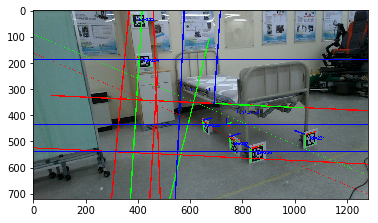

In [14]:
color_image = cv2.imread(os.path.join(path, 'color/color_0.jpg'))
aruco_map = get_aruco_map()
obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
img_out = aruco_map.draw_objects(color_image, obj_dict, corner_dict, cameraMatrix, distCoeffs)
plt.imshow(img_out[:,:,[2,1,0]])
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_co_gt = obj_dict['test_bed']
# T_co_gt[:3,3] = -T_co_gt[:3,3]
# T_bo = matmul_series(T_bc, SE3(Rot_axis(2, np.pi), (0,0,0)), T_co)
T_bo_gt = matmul_series(T_bc, T_co_gt)

In [15]:
gscene.add_highlight_axis("hl", "test_bed", T=T_bo_gt, dims=(0.2,0.04,0.04))
gscene.add_highlight_axis("hl", "tbc", T=T_bc, dims=(0.2,0.04,0.04))

In [44]:
from pkg.detector.aruco.detector import aruco_param
color_image = cv2.imread(os.path.join(path, 'color/color_13.jpg'))
aruco_map = get_aruco_map()
corners, ids, rejectedImgPoints = aruco.detectMarkers(color_image, aruco_map.dictionary, parameters=aruco_param)

In [28]:
image = np.copy(color_image)

In [29]:
# flatten the ArUco IDs list
ids = ids.flatten()
# loop over the detected ArUCo corners
for (markerCorner, markerID) in zip(corners, ids):
    # extract the marker corners (which are always returned in
    # top-left, top-right, bottom-right, and bottom-left order)
    corners = markerCorner.reshape((4, 2))
    (topLeft, topRight, bottomRight, bottomLeft) = corners
    # convert each of the (x, y)-coordinate pairs to integers
    topRight = (int(topRight[0]), int(topRight[1]))
    bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
    bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
    topLeft = (int(topLeft[0]), int(topLeft[1]))

    cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
    cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
    cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
    cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
    # compute and draw the center (x, y)-coordinates of the ArUco
    # marker
    cX = int((topLeft[0] + bottomRight[0]) / 2.0)
    cY = int((topLeft[1] + bottomRight[1]) / 2.0)
    cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
    # draw the ArUco marker ID on the image
    cv2.putText(image, str(markerID),(topLeft[0], topLeft[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, (0, 255, 0), 2)
    print("[Inference] ArUco marker ID: {}".format(markerID))

[Inference] ArUco marker ID: 232
[Inference] ArUco marker ID: 230
[Inference] ArUco marker ID: 231
[Inference] ArUco marker ID: 234
[Inference] ArUco marker ID: 232
[Inference] ArUco marker ID: 233
[Inference] ArUco marker ID: 235


In [45]:
frame = np.copy(color_image)

In [46]:
Tmark_dict = {}
# If markers are detected
if len(corners) > 0:
    for i in range(0, len(ids)):
        # Estimate pose of each marker and return the values rvec and tvec---(different from those of camera coefficients)
        rvec, tvec = \
            cv2.aruco.estimatePoseSingleMarkers(
            corners[i], 0.15, cameraMatrix, distCoeffs)
        # Draw a square around the markers
        cv2.aruco.drawDetectedMarkers(frame, corners) 

        # Draw Axis
        cv2.aruco.drawAxis(frame, cameraMatrix, distCoeffs, rvec, tvec, 0.1)  
        
        
        R, jac = cv2.Rodrigues(rvec)
        Tmark = SE3(R, tvec.flatten())
        Tmark_dict[ids[i][0]] = np.matmul(T_bc, Tmark)

In [47]:
for k, Tmark in Tmark_dict.items():
    gscene.add_highlight_axis("hl", "mark_{}".format(k), T=Tmark)

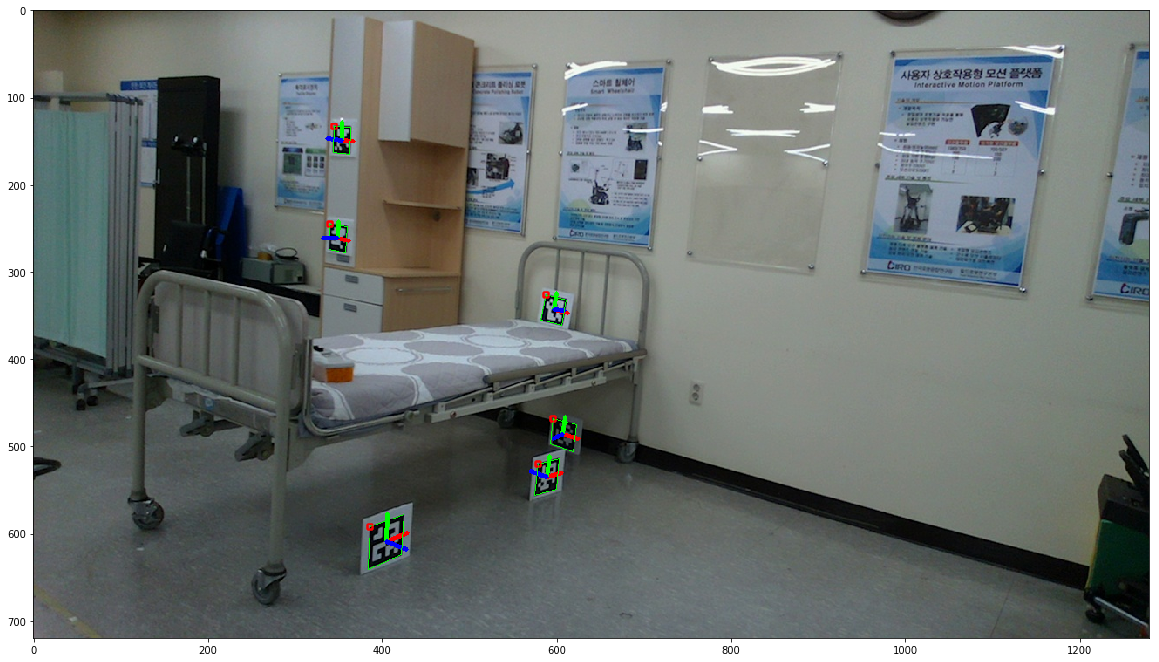

In [48]:
plt.figure(figsize=(20,15))
plt.imshow(frame[:,:,[2,1,0]])

In [7]:
bed_iou = []
closet_iou = []

In [8]:
for j in range(11):
    color_path = os.path.join(path, 'color_segmented/color_mask_{}.jpg'.format(j))
    depth_path = os.path.join(path, 'depth_segmented/depth_mask_{}.png'.format(j))
    cdp_masked = load_cdp(color_path, depth_path)

    icp_bed = MultiICP(model='model_CAD/bed/bed.STL',
                     Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]), scale=[1e-3,1e-3,1e-3])
    icp_bed.add_image(cdp_masked, Tc=None)


    Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                                   offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))

    T_co1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.2, visualize=False)
    T_co2, fitness2 = icp_bed.compute_front_ICP(Tc_cur=np.identity(4), To=T_co1, thres=0.1, visualize=False)
    T_co_bed = T_co2
    T_bo_bed = np.matmul(T_bc, T_co2)

    color_image = cv2.imread(os.path.join(path, 'color/color_{}.jpg'.format(j)))
    objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)

    T_co_gt = objectPose_dict['test_bed']
    T_co_gt[:3,3] = -T_co_gt[:3,3]
    # T_bo = matmul_series(T_bc, SE3(Rot_axis(2, np.pi), (0,0,0)), T_co)
    T_bo_gt = matmul_series(T_bc, T_co_gt, SE3(Rot_axis(3, np.pi), (0,0,0)))


    T_off = np.matmul(SE3_inv(T_bo_gt), T_bo_bed)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=(0,0,0))
    scale=[1e-3,1e-3,1e-3]

    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=(0,0,0))
    
    bed_mesh = o3d.io.read_triangle_mesh('model_CAD/bed/bed.STL')
    bed_mesh_gt = o3d.io.read_triangle_mesh('model_CAD/bed/bed.STL')
    bed_mesh.vertices = o3d.utility.Vector3dVector(
                    np.asarray(bed_mesh.vertices) * np.array([scale[0], scale[1], scale[2]]))
    bed_mesh_gt.vertices = o3d.utility.Vector3dVector(
                    np.asarray(bed_mesh_gt.vertices) * np.array([scale[0], scale[1], scale[2]]))
    bed_mesh.transform(T_off)
    # mesh_gt.transform(T_co_gt)
    # aabox = mesh.get_oriented_bounding_box()
    # aabox_gt = mesh_gt.get_oriented_bounding_box()
    aabox = bed_mesh.get_axis_aligned_bounding_box()
    aabox_gt = bed_mesh_gt.get_axis_aligned_bounding_box()

#     o3d.visualization.draw_geometries([bed_mesh, aabox, bed_mesh_gt, aabox_gt, origin])
    points = np.asarray(aabox.get_box_points())
    points_gt = np.asarray(aabox_gt.get_box_points())
    # points = points[points[:,2].argsort()[::-1]]
    # points_gt = points_gt[points_gt[:,2].argsort()[::-1]]

    #     iou_3d = get_3d_iou(aabox, aabox_gt, points, points_gt)
    iou_3d = get_iou_3d(aabox, aabox_gt, points, points_gt, T_off)
    bed_iou.append(iou_3d)

Apply point-to-point ICP
registration::RegistrationResult with fitness=6.939700e-01, inlier_rmse=9.032991e-02, and correspondence_set size of 23604
Access transformation to get result.
Transformation is:
[[ 0.88552297 -0.16301519  0.4350576  -0.50077887]
 [-0.27879174 -0.93553369  0.21691447  0.23046032]
 [ 0.37165069 -0.31337321 -0.87388386  4.34082245]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.326311e-01, inlier_rmse=4.061747e-02, and correspondence_set size of 9051
Access transformation to get result.
Transformation is:
[[ 0.90674457 -0.06515822  0.41661576 -0.47989693]
 [-0.16505853 -0.96399915  0.20847378  0.23154739]
 [ 0.38803346 -0.25779845 -0.88485592  4.35678638]
 [ 0.          0.          0.          1.        ]]
('IOU_3d:', 0.6783421698743325)
Apply point-to-point ICP
registration::RegistrationResult with fitness=9.239486e-01, inlier_rmse=9.187190e-02, and correspondence_set size of 36690
Acc

Access transformation to get result.
Transformation is:
[[ 0.90041048 -0.05660606  0.43134293 -0.32498388]
 [-0.14929847 -0.97149047  0.18416359  0.61341908]
 [ 0.40862077 -0.23022167 -0.8831914   4.63623134]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.212382e-01, inlier_rmse=4.059349e-02, and correspondence_set size of 6651
Access transformation to get result.
Transformation is:
[[ 0.90667274  0.02653866  0.42099909 -0.30124902]
 [-0.0485405  -0.98482589  0.16661867  0.6392962 ]
 [ 0.41903265 -0.17150412 -0.89162659  4.65432276]
 [ 0.          0.          0.          1.        ]]
('IOU_3d:', 0.6766383487001724)


In [10]:
np.savetxt('bed_iou_result.txt', np.array(bed_iou))

In [ ]:
color_path = os.path.join(path, 'color/color_{}.jpg'.format(j))
depth_path = os.path.join(path, 'depth/depth_{}.png'.format(j))
cdp = load_cdp(color_path, depth_path)

icp_closet = MultiICP(model='model_CAD/top_table/top_table.STL',
                 Toff=SE3(np.identity(3),(0,0,0)), scale=[1e-3,1e-3,1e-3])
icp_closet.add_image(cdp_masked, Tc=None)

pcd_top_table = icp_closet.pcd
points = np.asarray(pcd_top_table.points)
points_4d = []
points_temp = []
points_transformed = []
for i in range(len(points)):
    points_4d.append(np.hstack([points[i], [1]]))

for i in range(len(points_temp)):
    points_transformed.append(np.matmul(SE3_inv(T_co_bed), points_4d[i]))

points_transformed_np = np.array(points_transformed)[:,:3]

bed_dims = (2.02, 0.91)
# Remove background based on bed_vis coord
out_x = np.where(points_transformed_np[:,0]>0)[0]
out_x2 = np.where(points_transformed_np[:,0]<-bed_dims[1])[0]
out_z = np.where(points_transformed_np[:,2]>bed_dims[0])[0]
out_z2 = np.where(points_transformed_np[:,2]<0)[0]
out_y = np.where(points_transformed_np[:,1]<floor_margin)[0]
out_all = sorted(set(out_x).union(out_y).union(out_z).union(out_x2).union(out_z2))
in_all = sorted(set(np.arange(len(points_transformed_np))) - set(out_all))
points_transformed = np.array(points_transformed)[in_all, :3]

# Reconvert points w.r.t camera coord
points_recovered = np.matmul(T_co_bed[:3,:3], points_transformed.transpose()).transpose() + T_co_bed[:3,3]

pcd_top_table = o3d.geometry.PointCloud()
pcd_top_table.points = o3d.utility.Vector3dVector(points_recovered)
icp_closet.pcd = pcd_top_table


Tguess = icp_closet.get_initial_by_center(Rot_axis(3,np.pi), offset=(0,0,0.3)-(0,0,1))
T_co1, fitness1 = icp_closet.compute_ICP(To=Tguess, thres=0.2, visualize=False)
T_co_closet = T_co1

color_image = cv2.imread(os.path.join(path, 'color/color_{}.jpg'.format(j)))
objectPose_dict, corner_dict = aruco_map.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)

T_cm = objectPose_dict['test_closet']
T_mo = SE3(Rot_axis(3,np.pi), (1.1*0.7,0,-0.6))
T_co_gt = np.matmul(T_cm, T_mo)
T_off = np.matmul(SE3_inv(T_co_gt), T_co_closet)

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=(0,0,0))

closet_mesh = o3d.io.read_triangle_mesh('model_CAD/top_table/top_table.STL')
closet_mesh_gt = o3d.io.read_triangle_mesh('model_CAD/top_table/top_table.STL')
closet_mesh.vertices = o3d.utility.Vector3dVector(
    np.asarray(closet_mesh.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))
closet_mesh_gt.vertices = o3d.utility.Vector3dVector(
    np.asarray(closet_mesh_gt.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))
closet_mesh.transform(T_off)
# mesh_gt.transform(T_co_gt)
aabox = bed_mesh.get_oriented_bounding_box()
aabox_gt = bed_mesh_gt.get_oriented_bounding_box()

#     o3d.visualization.draw_geometries([mesh, aabox, mesh_gt, aabox_gt, origin])

points = np.asarray(aabox.get_box_points())
points_gt = np.asarray(aabox_gt.get_box_points())
# points = points[points[:,2].argsort()[::-1]]
# points_gt = points_gt[points_gt[:,2].argsort()[::-1]]

#     iou_3d = get_3d_iou(aabox, aabox_gt, points, points_gt)
iou_3d = get_iou_3d(aabox, aabox_gt, points, points_gt, T_off)
closet_iou.append(iou_3d)